# Инициализация

In [0]:
#@markdown - **Монтирование GoogleDrive** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **Размонтирование**
# !fusermount -u GoogleDrive

# Область кодов

In [0]:
#@title Генеративно-состязательные сети { display-mode: "both" }
# В программе реализованы простые генеративно-состязательные сети
# Одновременно обучать генеративные и дискриминантные сети
# Также можно обучать дискриминантные сети, а затем обучать генеративные сети
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as scio

tf.logging.set_verbosity(tf.logging.ERROR)

# Считывание данных
from tensorflow.examples.tutorials.mnist import input_data

#@markdown - **Xavier Glorot инициализация переменных**
def glorot_init(shape):
    return tf.truncated_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

def bias_init(shape):
    return tf.random_normal(shape=shape, stddev=.1)

In [0]:
#@markdown - **Настройка параметров сетей**
mnist = input_data.read_data_sets('sample_data/MNIST_data', one_hot=True)

# Параметры обучения
init_rate = 5e-4 #@param {type: "number"}
decay_steps = 2000 #@param {type: "number"}
num_epochs = 70000 #@param {type: "integer"}
batch_size = 128 #@param {type: "integer"}

# Параметры сетей
img_dim = mnist.train.images[0].shape[-1]
gen_hidden_dim = 320
disc_hidden_dim = 320
feature_dim = 196
disc_output_dim = 1

Extracting sample_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting sample_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting sample_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting sample_data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
#@markdown - **Адресы журналов и моделей**
file_path = 'GoogleDrive/My Drive/Colab Notebooks'
checkpoint_path = os.path.join(file_path, 'Checkpoints')
event_path = os.path.join(file_path, 'Tensorboard')

In [0]:
#@markdown - **Основные коды**
#@markdown - **Структура graph**
graph = tf.Graph()
with graph.as_default():

    global_step = tf.Variable(0, name='global_step', trainable=False)
    decay_rate = 0.9
    # learning rate с экспоненциальным затуханием
    learning_rate = tf.train.exponential_decay(init_rate, global_step=global_step,
                                                decay_steps=decay_steps, 
                                                decay_rate=decay_rate, 
                                                staircase=False, 
                                                name='exponential_decay')

    with tf.name_scope('Input'):
        gen_input = tf.placeholder(tf.float32, [None, feature_dim], name='random_noises')
        disc_input = tf.placeholder(tf.float32, [None, img_dim], name='real_images')

    with tf.name_scope('Weights_and_biases'):
        weights = {
            'gen_h': tf.Variable(glorot_init([feature_dim, gen_hidden_dim]), name='gen_w1'),
            'gen_o': tf.Variable(glorot_init([gen_hidden_dim, img_dim]), name='gen_w2'),
            'disc_h': tf.Variable(glorot_init([img_dim, disc_hidden_dim]), name='disc_w1'),
            'disc_o': tf.Variable(glorot_init([disc_hidden_dim, disc_output_dim]), name='disc_w2'),
            }
        biases = {
            'gen_b1': tf.Variable(bias_init([gen_hidden_dim]), name='gen_b1'),
            'gen_b2': tf.Variable(bias_init([img_dim]), name='gen_b2'),
            'disc_b1': tf.Variable(bias_init([disc_hidden_dim]), name='disc_b1'),
            'disc_b2': tf.Variable(bias_init([disc_output_dim]), name='disc_b2'),
            }
    with tf.name_scope('Generator_and_Discriminator'):
        # Создание генеративных сетей
        def generator(x):
            layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['gen_h']),
                                            biases['gen_b1']))
            layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['gen_o']),
                                            biases['gen_b2']))
            return layer_2

        # Создание дискриминантных сетей
        def discriminator(x):
            layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['disc_h']),
                                           biases['disc_b1']))
            layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['disc_o']),
                                           biases['disc_b2']))
            return layer_2

    with tf.name_scope('Main_structure'):
        gen_sample = generator(gen_input)
        gen_imgs = tf.reshape(gen_sample, [-1, 28, 28, 1], name='gen_imgs')
        disc_fake = discriminator(gen_sample)
        disc_real = discriminator(disc_input)

    with tf.name_scope('Loss'):
        gen_loss = -tf.reduce_mean(tf.log(disc_fake + 1e-10))
        disc_loss = -tf.reduce_mean(tf.log(disc_real + 1e-10) + tf.log(1. - disc_fake))

    with tf.name_scope('Train'):
        optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
        optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)
        # Определить переменные, которые необходимо обновлять отдельно для каждого epoch
        # Список переменных генеративных сетей
        gen_vars = [weights['gen_h'], weights['gen_o'],
                    biases['gen_b1'], biases['gen_b2']]
        # Список переменных дискриминатных сетей
        disc_vars = [weights['disc_h'], weights['disc_o'],
                    biases['disc_b1'], biases['disc_b2']]

        trainop_gen = optimizer_gen.minimize(gen_loss, global_step=global_step, var_list=gen_vars)
        # trainop_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
        trainop_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)


In [0]:
#@markdown - **Обучение модели**
with tf.Session(graph=graph) as sess:
  
    sess.run(tf.global_variables_initializer())

    # Start Training
    gen_loss_list = []
    disc_loss_list = []
    for epoch in range(num_epochs):
        batch, _ = mnist.train.next_batch(batch_size)
        random_noise = np.random.uniform(-1., 1., size=[batch_size, feature_dim])
        _, _, l_g, l_d = sess.run([trainop_gen, trainop_disc, gen_loss, disc_loss], 
                                            feed_dict={gen_input: random_noise, disc_input: batch})

        if (epoch + 1) % 100 == 0:
            gen_loss_list.append(l_g)
            disc_loss_list.append(l_d)
        # # Также можно обучать дискриминантные сети, а затем обучать генеративные сети
        # _, l_d = sess.run([trainop_disc, disc_loss], feed_dict={gen_input: random_noise, 
        #                                                         disc_input: batch})
        # if (epoch+1) % 2 == 0:
        #     _, l_g = sess.run([trainop_gen, gen_loss], feed_dict={gen_input: random_noise,
        #                                                             disc_input: batch})
        print_list = [epoch+1, l_g, l_d]
        if (epoch+1) % 2000 == 0 or (epoch+1) == 1:
            print('Epoch {0[0]}: Generator Loss: {0[1]:.4f}, Discriminator Loss: {0[2]:.4f}.'.format(print_list))

    data_name = os.path.join(event_path, 'loss_data.mat')
    loss_data = {'gen_loss': np.array(gen_loss_list),
                'disc_loss': np.array(disc_loss_list)}
    scio.savemat(data_name, loss_data)
#     loss_data = scio.loadmat(data_name)

    #@markdown - **Генерация изображения 1 из шума путем генеративных сетей**
    n = 6
    canvas = np.empty((28 * n, 28 * n))
    for i in range(n):
        # Noise input.
        z = np.random.uniform(-1., 1., size=[n, feature_dim])
        # Generate image from noise.
        g = sess.run(gen_sample, feed_dict={gen_input: z})
        # Reverse colours for better display
        g =  1 - g
        for j in range(n):
            # Draw the generated digits
            canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])
    
    #@markdown - **Генерация изображения 2 из шума путем генеративных сетей**
    z = np.random.uniform(-1., 1., size=[36, feature_dim])
    # Generate image from noise.
    g = sess.run(gen_sample, feed_dict={gen_input: z})
sess.close()

Epoch 1: Generator Loss: 0.9385, Discriminator Loss: 1.3165.
Epoch 2000: Generator Loss: 5.6417, Discriminator Loss: 0.0120.
Epoch 4000: Generator Loss: 5.1716, Discriminator Loss: 0.0270.
Epoch 6000: Generator Loss: 4.5441, Discriminator Loss: 0.1756.
Epoch 8000: Generator Loss: 3.9634, Discriminator Loss: 0.1237.
Epoch 10000: Generator Loss: 4.2942, Discriminator Loss: 0.2219.
Epoch 12000: Generator Loss: 3.9269, Discriminator Loss: 0.2307.
Epoch 14000: Generator Loss: 3.5430, Discriminator Loss: 0.2354.
Epoch 16000: Generator Loss: 3.3138, Discriminator Loss: 0.2995.
Epoch 18000: Generator Loss: 3.6127, Discriminator Loss: 0.3277.
Epoch 20000: Generator Loss: 3.3562, Discriminator Loss: 0.3780.
Epoch 22000: Generator Loss: 2.9222, Discriminator Loss: 0.4246.
Epoch 24000: Generator Loss: 2.7497, Discriminator Loss: 0.4125.
Epoch 26000: Generator Loss: 2.7442, Discriminator Loss: 0.3786.
Epoch 28000: Generator Loss: 2.8687, Discriminator Loss: 0.4810.
Epoch 30000: Generator Loss: 2.93

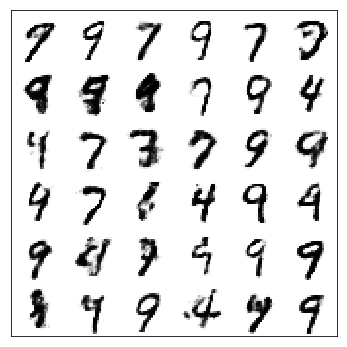

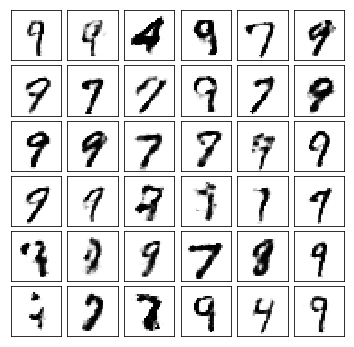

In [0]:
#@markdown - **Представление генеративных изображений**
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(n, n))
ax.imshow(canvas, cmap='gray')
ax.set_xticks([]), ax.set_yticks([])
img_name1 = os.path.join(event_path, 'generated_images_by_GAN1.jpg')
plt.savefig(img_name1)
plt.show()

fig, AX = plt.subplots(nrows=6, ncols=6, figsize=(6, 6))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
g = 1 - g
for i in range(6):
    for j in range(6):
        ax = AX[i, j]
        ax.imshow(g[i*6 + j].reshape([28, 28]), 'gray')
        ax.set_xticks([]), ax.set_yticks([])
img_name2 = os.path.join(event_path, 'generated_images_by_GAN2.jpg')
plt.savefig(img_name2)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


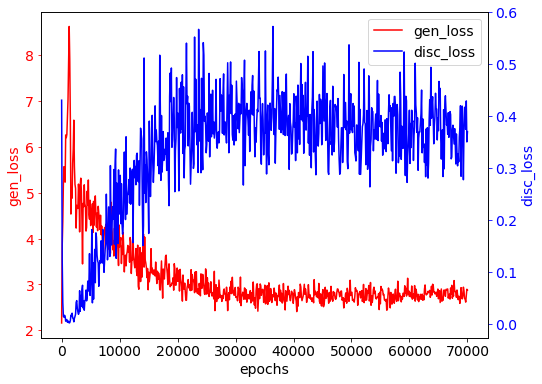

In [0]:
#@markdown - **plot gen_loss and disc_loss**
# scio.savemat(data_name, loss_data)
# loss_data = scio.loadmat(data_name)
x_data = np.linspace(1, num_epochs + 1, num_epochs / 100)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
par1 = ax.twinx()
p1, = ax.plot(x_data, loss_data['gen_loss'], 'r', label='gen_loss')
p2, = par1.plot(x_data, loss_data['disc_loss'], 'b', label='disc_loss')
ax.set_xlabel('epochs', fontsize=14)
ax.set_ylabel('gen_loss', fontsize=14)
par1.set_ylabel('disc_loss', fontsize=14)
ax.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
ax.tick_params(axis='y', colors=p1.get_color(), labelsize=14)
par1.tick_params(axis='y', colors=p2.get_color(), labelsize=14)
ax.tick_params(axis='x', labelsize=14)
lines = [p1, p2]
ax.legend(lines, [l.get_label() for l in lines], fontsize=14, loc='upper right')
img_name = os.path.join(event_path, 'gen_loss_and_disc_loss.jpg')
plt.savefig(img_name)
plt.show()